Hyrbid Importance Sampling with Markov Chains For Monte Crlo Integration

In [67]:

#==============================Dependencies================================

#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [68]:
# Gaussian proposal
def gaussian_proposal(x, step_size):
    return x + step_size * np.random.normal()

# Cauchy distribution: p(x) = 1 / (π * (1 + x^2))
def cauchy_distribution(x, step_size):
    return (step_size) * 1 / (pi * (1 + x**2))

# Uniform sampling proposal
def uniform_proposal(x, step_size):
    return x + step_size * rng.uniform(-1, 1)

In [69]:
#=======================Metropolis-Hastings Algorithm (Python)========================
def metropolis_python(f, N, x0, step_size, burnin, thinning, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    total_steps = N * thinning + burnin
    samples = []
    x = x0
    count = 0

    for i in range(total_steps):
        x_cand = gaussian_proposal(x, step_size)
        alpha = min(1.0, f(x_cand) / f(x))
        if rng.uniform() < alpha:
            x = x_cand
            count += 1
        if i >= burnin and (i - burnin) % thinning == 0:
            samples.append(x)
    acceptance_rate = count / total_steps
    
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(samples)

In [70]:
#Importing Cython for performance optimization
!/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install cython

%load_ext Cython

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [71]:
%%cython
#=======================Metropolis-Hastings Algorithm (Cython)========================

import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport fmin
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)

def metropolis_cython(int N, double x0, double step_size, int burnin, int thinning):
    cdef int total_steps = N * thinning + burnin
    cdef np.ndarray[np.double_t, ndim=1] samples = np.empty(N, dtype=np.double)
    cdef double x = x0
    cdef int i, count = 0
    cdef double x_cand, alpha, u

    for i in range(total_steps):
        x_cand = x + step_size * np.random.normal()
        alpha = fmin(1.0, (1.0 / (1.0 + x_cand * x_cand)) / (1.0 / (1.0 + x * x)))
        u = rand() / <double>RAND_MAX
        if u < alpha:
            x = x_cand
        if i >= burnin and (i - burnin) % thinning == 0:
            samples[count] = x
            count += 1
    samples.sort()
    return samples

In [72]:
def f(x):
    return 1 / (1 + x**2)  # Cauchy distribution

print("Metropolis-Hastings Python implementation loaded.", metropolis_python(f, 10000, rng.uniform(-1, 1), 4, 200, 1))

Acceptance rate: 0.45
Metropolis-Hastings Python implementation loaded. [ 4.08250823  4.08250823  4.08250823 ... -1.298718   -1.298718
  1.80896695]


The function average chain maker needs work, but its goal to to averae many different markov chains in the aim of lower the variane of the KDe pdf

In [73]:
#=======================Kernel Density Estimation (KDE) Functions========================

# Fixed-bandwidth KDE
def pilot_kde(samples, bandwidth): #fixed KDE mthod
    """Fixed-bandwidth KDE using Gaussian kernel."""
    def kde_eval(x_eval):
        x_eval = np.atleast_1d(x_eval)
        n = len(samples)
        coeff = 1 / (n * bandwidth * np.sqrt(2 * np.pi))
        diffs = (x_eval[:, None] - samples[None, :]) / bandwidth
        return coeff * np.sum(np.exp(-0.5 * diffs**2), axis=1)
    return kde_eval

def silverman_bandwidth(samples):
    n = len(samples)
    std = np.std(samples, ddof=1)
    return 1.06 * std * n ** (-1/5)

# Adaptive-bandwidth KDE
def adaptive_kde(samples, h_fixed, alpha=0.5): # Adative KDE method
    """
    Adaptive KDE using Abramson's square-root law.
    samples : 1D array of data points
    h_fixed : base bandwidth for pilot KDE
    alpha   : sensitivity parameter (default 0.5)
    """
    n = len(samples)

    # Step 1: pilot density estimate
    pilot = pilot_kde(samples, h_fixed)
    f_i = pilot(samples)

    # Step 2: compute geometric mean of pilot estimates
    g = np.exp(np.mean(np.log(f_i)))

    # Step 3: compute local bandwidth factors
    lambda_i = (f_i / g)**(-alpha)
    h_i = h_fixed * lambda_i

    # Step 4: adaptive KDE function
    def kde_adaptive(x_eval):
        x_eval = np.atleast_1d(x_eval)
        coeffs = 1 / (np.sqrt(2 * np.pi) * h_i)
        diffs = (x_eval[:, None] - samples[None, :]) / h_i
        result = np.sum(coeffs * np.exp(-0.5 * diffs**2), axis=1) / n
        return result

    return kde_adaptive

In [74]:
def hybrid_importance_sampling(f, m_chain, kde_pdf):
    """
    Estimate the integral of f using importance sampling from KDE-estimated proposal.

    Returns:
        estimate: Monte Carlo estimate of the integral
        stderr: Standard error of the estimate (not just std of weights)
    """
    weights = f(m_chain) / kde_pdf(m_chain)
    estimate = np.mean(weights)
    
    
    n = len(weights)
    variance = np.var(weights, ddof=1) / n    # variance of the estimator
    stderr = np.sqrt(variance) / np.sqrt(n)               # standard error of the estimator

    return estimate, variance, stderr


In [75]:
#========================Example Usage of Hybrid Importance Sampling========================
'''N=10000
m_chain = metropolis_python(f, N, rng.uniform(-1, 1), 4, 200, 1)
h_fixed = silverman_bandwidth(m_chain)
kde = adaptive_kde(m_chain, h_fixed, alpha=0.5)

print("Hybrid Importance Sampling Estimate:"),
hybrid_importance_sampling(f, m_chain, kde)'''

'N=10000\nm_chain = metropolis_python(f, N, rng.uniform(-1, 1), 4, 200, 1)\nh_fixed = silverman_bandwidth(m_chain)\nkde = adaptive_kde(m_chain, h_fixed, alpha=0.5)\n\nprint("Hybrid Importance Sampling Estimate:"),\nhybrid_importance_sampling(f, m_chain, kde)'

Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.78
Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.79
Acceptance rate: 0.77
Acceptance rate: 0.78
Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.77
Acceptance rate: 0.78
Acceptance rate: 0.77
Acceptance rate: 0.77


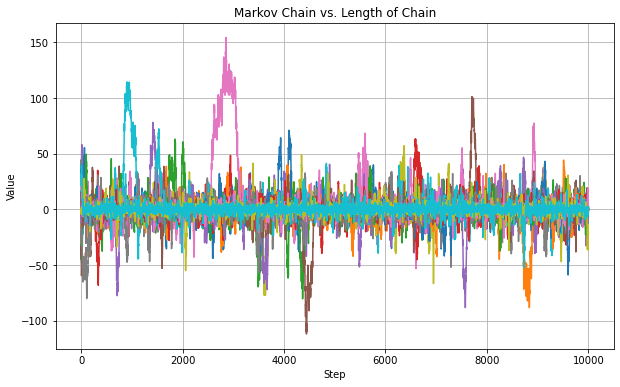

In [83]:
# Generate a Markov chain using the Metropolis-Hastings algorithm
N = 10000
plt.figure(figsize=(10, 6))
for i in range(30):
    m_chain = metropolis_python(f, N, rng.uniform(-40, 40), 1, 1, 20)

    # Plot the Markov chain against its length
    #plt.figure(figsize=(10, 6))
    plt.plot(range(len(m_chain)), m_chain, label="Markov Chain")
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Markov Chain vs. Length of Chain")
#plt.legend()
plt.grid()
plt.show()